In [2]:
import sys; sys.path.append('../../') 

from utils.data_cleaner import *
from data_collection_config import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

### Чтение и подготовка данных

In [ ]:
Goods = pd.read_csv(f'{CLEAR_DIRECTORY}{CLEAR_GOODS_FILE}')
Other_characteristicks = pd.read_csv(f'{CLEAR_DIRECTORY}{CLEAR_OTHER_CHARACTERISTICKS_FILE}')
Feedbacks = pd.read_csv(f'{CLEAR_DIRECTORY}{CLEAR_FEEDBACKS_FILE}')

def prepare_goods(df):
    df['brand'] = df['brand'].fillna('Unknown')
    df['description'] = df['description'].fillna('')
    df['brand'] = df['brand'].str.lower().str.strip()

    # mask = df['name'].apply(is_relevant())
    # df = df[mask].copy()
    
    return df

def prepare_other_chars(df):
    df['name'] = df['name'].str.lower().str.strip()
    df['value'] = df['value'].str.lower().str.strip()
    
    df = df[df['value'].notna() & (df['value'] != '')]
    
    return df

def prepare_feedbacks(df):
    df['text'] = df['text'].fillna('')
    
    df['text'] = df['text'].str.lower().str.strip()
    
    return df

Goods = prepare_goods(Goods)
Goods = Goods[(Goods['price'] >= Goods['price'].quantile(0.01)) & (Goods['price'] <= Goods['price'].quantile(0.95))]
Other_characteristicks = prepare_other_chars(Other_characteristicks)
Feedbacks = prepare_feedbacks(Feedbacks)

# Goods.info()
# Other_characteristicks.info()
# Feedbacks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25699 entries, 0 to 25698
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   good_id      25699 non-null  int64 
 1   marketplace  25699 non-null  object
 2   rating       25699 non-null  int64 
 3   text         25699 non-null  object
dtypes: int64(2), object(2)
memory usage: 803.2+ KB


# Анализ рынка электростимуляторов

## Введение

Необходимо понять, как выглядит текущая рыночная ситуация на рынке электродов для электростимуляторов. 

Были сформулированы 4 цели:
- Определить, в каком ценовом сегменте выгоднее всего конкурировать
- Понять, какие функции и характеристики наиболее популярны у потребителей
- Оценить уровень конкуренции
- Выявить возможные ниши

## Описание источников и подхода к сбору данных

Для достижения поставленных целей в первую очередь необходимо подготовить набор данных. Данные собраны с двух маркетплейсов: Wildberries и Ozon.
Для этих маркетплейсов были разработаны парсеры с помощью Python + requests/Selenium. Парсеры организованы в 2 класса: WB_Parser и Ozon_Parser. Данные классы имеют 3 открытых метода: 
- get_products() - собирает все имеющиеся товары на маркетплейсе, соответсвующие запросу; 
- get_product_feedbacks() - собирает отзывы на заданный товар;
- get_product_details() - собирает описание и характеристики заданного товара.

С обоих площадок было собрано > 2 000 товаров.

После сбора, данные были очищены и собраны в 3 таблицы:
- Goods (основные характеристики товаров)
- Feedbacks (отзывы пользователей)
- Other_characteristics (доп. характеристики)

В итоге получилось >400 товаров и >25 000 отзывов о них

Состав таблиц:

In [9]:
Goods.info()
Other_characteristicks.info()
Feedbacks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 443 entries, 0 to 471
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           443 non-null    int64  
 1   marketplace  443 non-null    object 
 2   name         443 non-null    object 
 3   price        443 non-null    int64  
 4   rating       443 non-null    float64
 5   feedbacks    443 non-null    int64  
 6   brand        443 non-null    object 
 7   description  443 non-null    object 
dtypes: float64(1), int64(3), object(4)
memory usage: 31.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4065 entries, 0 to 4064
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   good_id      4065 non-null   int64 
 1   marketplace  4065 non-null   object
 2   name         4065 non-null   object
 3   value        4065 non-null   object
dtypes: int64(1), object(3)
memory usage: 127.2+ KB
<class 'pandas

## Как выглядит рынок электродов? (Распределение цен)

In [10]:
price_data = Goods['price'].copy()

stats = {
    'Средняя цена': f"{price_data.mean():,.0f} руб",
    'Медианная цена': f"{price_data.median():,.0f} руб",
    'Минимальная цена': f"{price_data.min():,.0f} руб",
    'Максимальная цена': f"{price_data.max():,.0f} руб",
    'Стандартное отклонение': f"{price_data.std():,.0f} руб",
    '95-й перцентиль': f"{price_data.quantile(0.95):,.0f} руб"
}

print("Ключевые метрики распределения цен:")
for k, v in stats.items():
    print(f"{k}: {v}")

Ключевые метрики распределения цен:
Средняя цена: 650 руб
Медианная цена: 395 руб
Минимальная цена: 120 руб
Максимальная цена: 3,186 руб
Стандартное отклонение: 613 руб
95-й перцентиль: 2,118 руб


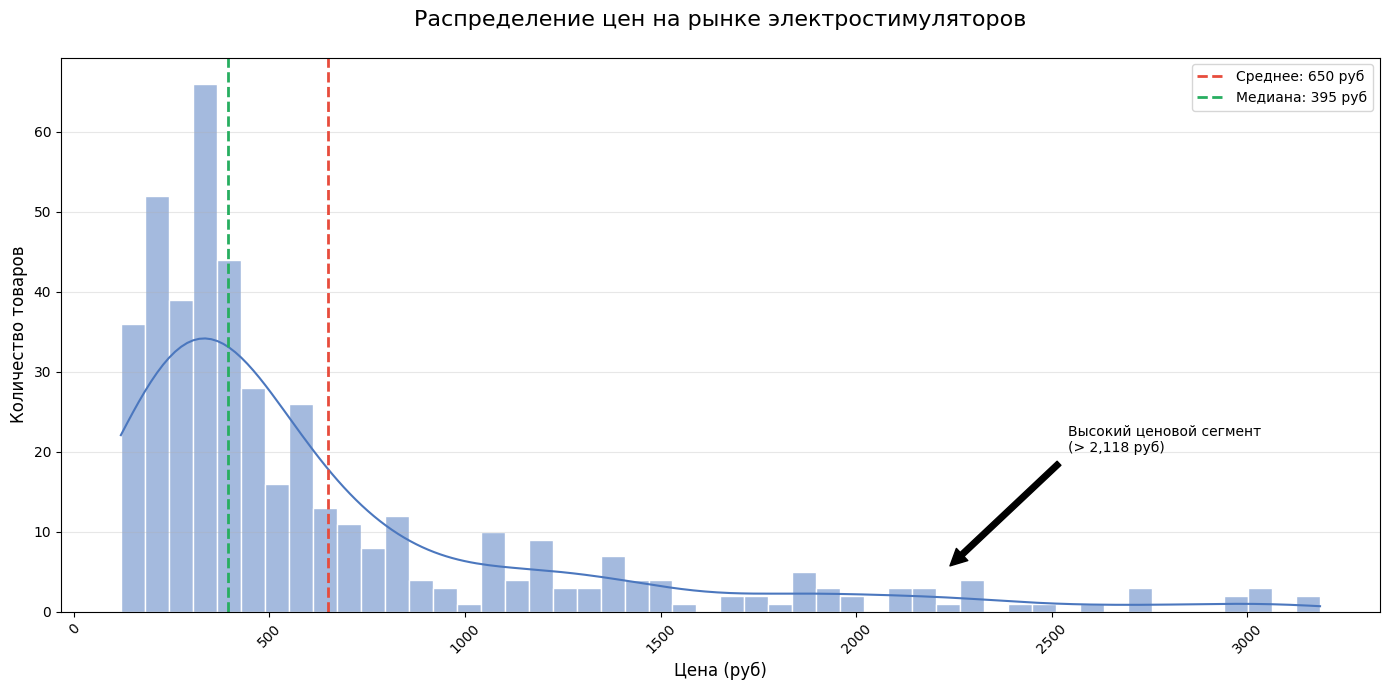

In [11]:
price_data = Goods["price"]

plt.figure(figsize=(14, 7))

ax = sns.histplot(price_data, bins=50, kde=True, 
                 color='#4B77BE', edgecolor='white')

mean_price = price_data.mean()
median_price = price_data.median()

plt.axvline(mean_price, color="#E74C3C", linestyle='--', 
           linewidth=2, label=f'Среднее: {mean_price:,.0f} руб')
plt.axvline(median_price, color='#27AE60', linestyle='--',
           linewidth=2, label=f'Медиана: {median_price:,.0f} руб')

q95 = price_data.quantile(0.95)
outliers = price_data[price_data > q95]
if len(outliers) > 0:
    plt.annotate(f'Высокий ценовой сегмент\n(> {q95:,.0f} руб)',
                xy=(q95*1.05, 5), xytext=(q95*1.2, 20),
                arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('Распределение цен на рынке электростимуляторов\n', fontsize=16)
plt.xlabel('Цена (руб)', fontsize=12)
plt.ylabel('Количество товаров', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [12]:
from sklearn.cluster import KMeans

price_segment_clear_df = Goods.copy()

prices = price_segment_clear_df["price"].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=4, random_state=42).fit(prices)
price_segment_clear_df['price_segment'] = kmeans.labels_

def min_max(price_segment, df):
    return int(df[df["price_segment"] == price_segment]["price"].min()), int(df[df["price_segment"] == price_segment]["price"].max())

min_max_segments = {}
for i in range(4):
    min_max_segments[i] = min_max(i, price_segment_clear_df)

min_max_segments = sorted(min_max_segments.items(), key=lambda item: item[1] )

print(f"Низкий ценовой сегмент: {min_max_segments[0][1]}")
print(f"Средний ценовой сегмент: {min_max_segments[1][1]}")
print(f"Средне-высокий ценовой сегмент:{min_max_segments[2][1]}")
print(f"Высокий ценовой сегмент:  {min_max_segments[3][1]}")

Низкий ценовой сегмент: (120, 452)
Средний ценовой сегмент: (459, 954)
Средне-высокий ценовой сегмент:(1039, 1756)
Высокий ценовой сегмент:  (1826, 3186)


In [14]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

def get_segment_stats(segment_df, segment_name, top_n):
    stats = {
        'Сегмент': segment_name,
        'Кол-во товаров': len(segment_df),
        'Доля товаров без бренда': len(segment_df[segment_df['brand'] == 'unknown']) / len(segment_df),
        'Средний рейтинг': segment_df['rating'].median(),
        'Среднее кол-во отзывов': segment_df['feedbacks'].median()
    }
    
    # Топ брендов
    top_brands = segment_df['brand'].value_counts().head(top_n)
    stats.update({
        f'топ {top_n} брендов': '; '.join([f"{brand} ({count})" for (brand, count) in top_brands.items()])
    })
    
    # # Топ зон
    # zones = segment_df['zones'].str.split('[;,/]', expand=True).stack().str.strip()
    # top_zones = zones.value_counts().head(top_n)
    # stats.update({
    #     f'топ {top_n} зон': '; '.join([f"{zone} ({count})" for (zone, count) in top_zones.items()])
    # })
    
    # # Топ типов питания
    # power_type = segment_df['power_type'].str.split('[;,/]', expand=True).stack().str.strip()
    # top_power = power_type.value_counts().head(top_n)
    # stats.update({
    #     f'топ {top_n} типов питания': '; '.join([f"{power} ({count})" for (power, count) in top_power.items()])
    # })
    
    # # Топ типов
    # types = segment_df['type'].str.split('[;,/]', expand=True).stack().str.strip()
    # top_types = types.value_counts().head(top_n)
    # stats.update({
    #     f'топ {top_n} типов': '; '.join([f"{type} ({count})" for (type, count) in top_types.items()])
    # })
    
    return stats


low_price_df = price_segment_clear_df[price_segment_clear_df["price_segment"] == min_max_segments[0][0]]
mid_price_df = price_segment_clear_df[price_segment_clear_df["price_segment"] == min_max_segments[1][0]]
mid_high_price_df = price_segment_clear_df[price_segment_clear_df["price_segment"] == min_max_segments[2][0]]
high_price_df = price_segment_clear_df[price_segment_clear_df["price_segment"] == min_max_segments[3][0]]

segments = {
    'Низкий': low_price_df,
    'Средний': mid_price_df,
    'Средне-высокий': mid_high_price_df,
    'Высокий': high_price_df
}

top_n = 5
all_stats = [get_segment_stats(df, name, top_n) for name, df in segments.items()]
result_df = pd.DataFrame(all_stats)

display(result_df)
pd.reset_option('display.max_colwidth')

,Сегмент,Кол-во товаров,Доля товаров без бренда,Средний рейтинг,Среднее кол-во отзывов,топ 5 брендов
0,Низкий,245,0.016327,4.90,35.0,миостимуляторы (81); массажеры (65); ashop (14); wikielement (11); allershop (10)
1,Средний,113,0.044248,4.90,51.0,миостимуляторы (27); массажеры (21); миостимулятор (13); beurer (6); ashop (6)
2,Средне-высокий,50,0.060000,4.45,1.0,noname (22); миостимуляторы (7); unknown (3); массажеры (3); beurer (2)
3,Высокий,35,0.000000,4.90,4.0,compex (15); миоток (4); electrodes for massagers (3); yamaguchi (3); noname (2)


Рынок развит, на рынке присутствует большое количество товаров на любой кошелек. 95% товаров представлено в ценовом сегменте до 5 415 рублей. 

Наиболее популярными и наименее конкуретными являются средне-высокий и высокий ценовые сегменты (на основании среднего количества отзывов и количества представленных на рынке товаров)

Наиболее конкуретными являются низкий и средний ценовые сегменты.

/var/folders/x5/m9f65fq57_1642g0ls7c0zxw0000gn/T/ipykernel_65826/1095736399.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


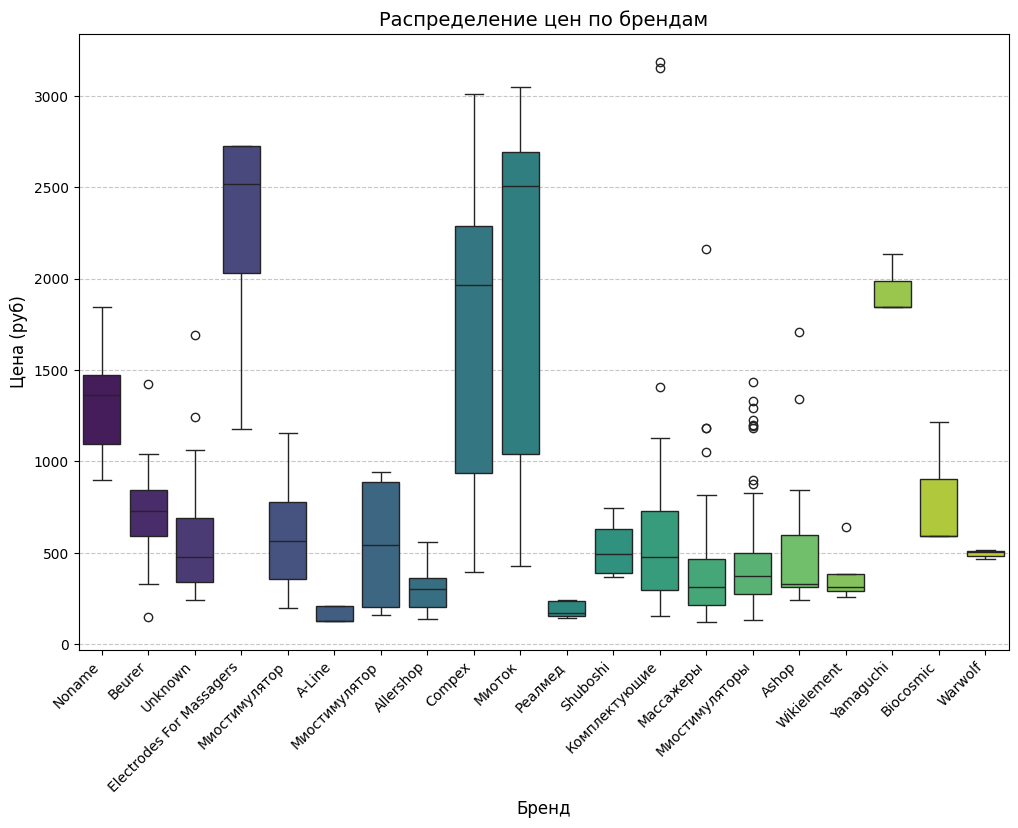

In [15]:
clear_df = Goods.copy()

boxplot_df = clear_df.dropna(subset=["brand"])
boxplot_df['brand'] = boxplot_df['brand'].str.strip().str.title()

top_brands = boxplot_df['brand'].value_counts().head(20).index  # Топ-20 брендов
df_filtered = boxplot_df[boxplot_df['brand'].isin(top_brands)]

plt.figure(figsize=(12, 8))
sns.boxplot(
    data=df_filtered,
    x='brand',
    y='price',
    palette='viridis'
)
plt.title('Распределение цен по брендам', fontsize=14)
plt.xlabel('Бренд', fontsize=12)
plt.ylabel('Цена (руб)', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Поворот подписей
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

В основном товары представлены неизвестными брендами.

## Реакция потребителей (Анализ отзывов и рейтингов)

Что касается самых популярных характерстик:

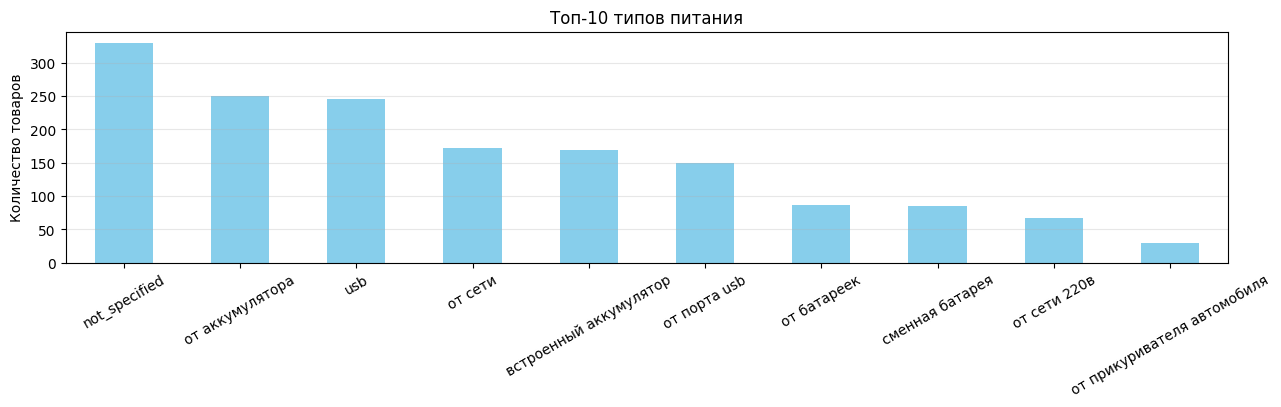

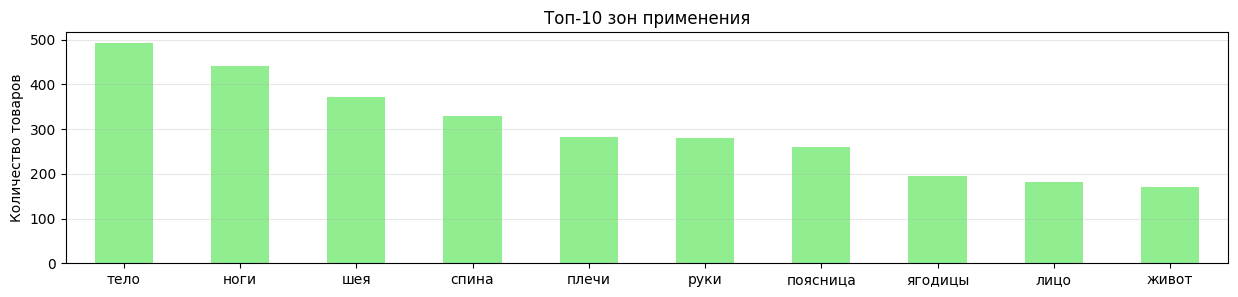

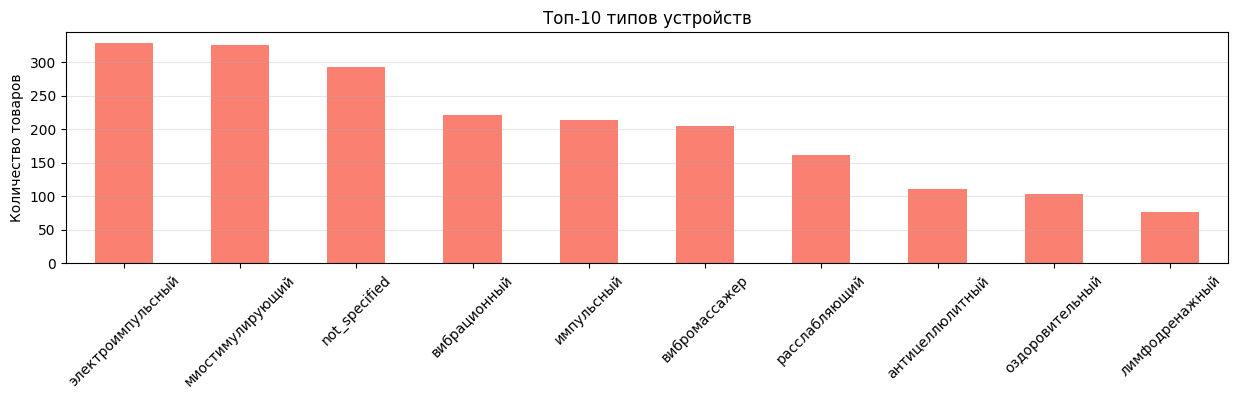

In [61]:
power_types = Goods['power_type'].str.split('[;,/]', expand=True).stack().str.strip()

figsize = (15, 3)

plt.figure(figsize=figsize)
power_types.value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title('Топ-10 типов питания')
plt.ylabel('Количество товаров')
plt.xticks(rotation=30)
plt.grid(axis='y', alpha=0.3)
plt.show()

zones = Goods['zones'].str.split('[;,/]', expand=True).stack().str.strip()

plt.figure(figsize=figsize)
zones.value_counts().head(10).plot(kind='bar', color='lightgreen')
plt.title('Топ-10 зон применения')
plt.ylabel('Количество товаров')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

types = Goods['type'].str.split('[;,/]', expand=True).stack().str.strip()

plt.figure(figsize=figsize)
types.value_counts().head(10).plot(kind='bar', color='salmon')
plt.title('Топ-10 типов устройств')
plt.ylabel('Количество товаров')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

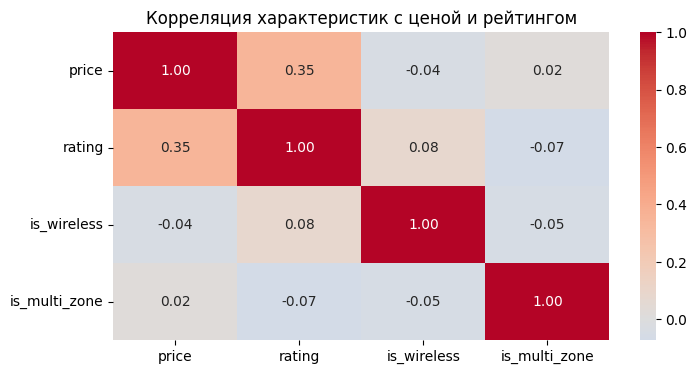

In [62]:
df = Goods.copy()
df['is_wireless'] = df['power_type'].str.contains('аккумулятор|батарея|USB', regex=True, na=False).astype(int)
df['is_multi_zone'] = (df['zones'].str.count(';') > 1).fillna(0).astype(int)

corr_matrix = df[['price', 'rating', 'is_wireless', 'is_multi_zone']].corr()
plt.figure(figsize=(8, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Корреляция характеристик с ценой и рейтингом')
plt.show()

Мы видим, что на рынке представлены в основном автономные, мульти-зонные устройства (также они чуть дешевле). 

Судя по корреляции рейтинга и цены мы видим, что пользователи готовы переплачивать за товары более высокого качества. Это также видно и на следующем графике:

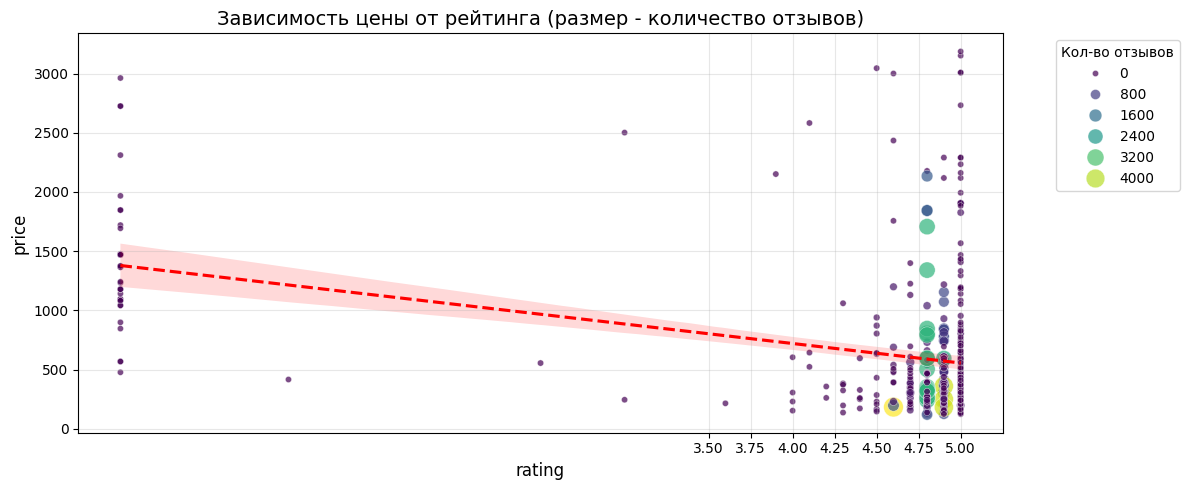

In [16]:
plt.figure(figsize=(12, 5))
sns.scatterplot(data=Goods, x='rating', y='price', 
                hue='feedbacks', size='feedbacks',
                sizes=(20, 200), alpha=0.7, palette='viridis')

plt.title('Зависимость цены от рейтинга (размер - количество отзывов)', fontsize=14)
plt.xlabel('Рейтинг', fontsize=12)
plt.ylabel('Цена (руб)', fontsize=12)
plt.xticks(np.arange(3.5, 5.1, 0.25))
plt.grid(alpha=0.3)
plt.ticklabel_format(style='plain', axis='y')

# Добавляем линию тренда
sns.regplot(data=Goods, x='rating', y='price', 
           scatter=False, color='red', line_kws={'linestyle':'--'})

plt.legend(title='Кол-во отзывов', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

Мы видим устойчивую зависимость рейтинга от цены. Это подтверждается и матрицей корреляции.

/var/folders/x5/m9f65fq57_1642g0ls7c0zxw0000gn/T/ipykernel_65826/1849547179.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clear_df, x='rating_group', y='price',


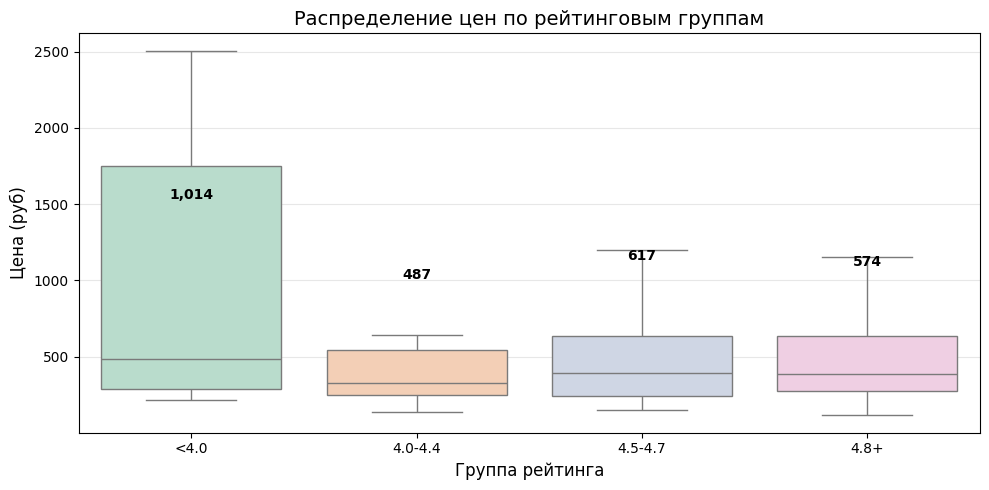

In [17]:
plt.figure(figsize=(10, 5))

clear_df = Goods.copy()

clear_df['rating_group'] = pd.cut(clear_df['rating'], 
                                   bins=[0, 3.9, 4.4, 4.7, 5],
                                   labels=['<4.0', '4.0-4.4', '4.5-4.7', '4.8+'])

sns.boxplot(data=clear_df, x='rating_group', y='price', 
           palette='Pastel2', showfliers=False)

plt.title('Распределение цен по рейтинговым группам', fontsize=14)
plt.xlabel('Группа рейтинга', fontsize=12)
plt.ylabel('Цена (руб)', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Добавляем средние значения
means = clear_df.groupby('rating_group', observed=False)['price'].mean()
for i, mean in enumerate(means):
    plt.text(i, mean+500, f'{mean:,.0f}', 
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

В целом товары с высоким рейтином есть во всех ценовых сегментах, однако подавляющее большинство товаров с высоким рейтингом это средний и средне-высокий ценовые сегменты.
Товары с низким рейтингом - это в первую очередь низкий ценовой сегмент.

In [65]:
high_rating_threshold = Goods['rating'].quantile(0.9)
high_feedback_threshold = Goods['feedbacks'].quantile(0.75)

popular_high_rated = Goods[
    (Goods['rating'] >= high_rating_threshold) & 
    (Goods['feedbacks'] >= high_feedback_threshold)
].sort_values(by=['rating', 'feedbacks'], ascending=[False, False])

# Добавляем расчет отношения рейтинга к цене
popular_high_rated['rating_price_ratio'] = popular_high_rated['rating'] / popular_high_rated['price']

results = [
    ['Топ-10 брендов', popular_high_rated['brand'].value_counts().head(10)],
    ['Типы питания', popular_high_rated['power_type'].value_counts().head(5)],
    ['Зоны применения', popular_high_rated['zones'].str.split('[;,/]', expand=True).stack().str.strip().value_counts().head(5)],
    ['Средняя цена', f"{popular_high_rated['price'].mean():,.0f} руб"]
]

def series_to_str(series, sep="; "):
    if isinstance(series, pd.Series):
        return sep.join(f"{k} ({v})" for k, v in series.items())
    return series

formatted_results = [
    [name, series_to_str(data)] 
    for name, data in results
]

results_df = pd.DataFrame(formatted_results, columns=['Аналитический показатель', 'Результат'])

pd.set_option('display.max_colwidth', None)
print("Аналитика товаров с высоким рейтингом и большим количеством отзывов")
display(results_df)

popular_high_rated['norm_rating'] = (popular_high_rated['rating'] - Goods['rating'].min()) / (Goods['rating'].max() - Goods['rating'].min())
popular_high_rated['norm_feedbacks'] = (popular_high_rated['feedbacks'] - Goods['feedbacks'].min()) / (Goods['feedbacks'].max() - Goods['feedbacks'].min())

# Расчет индекса
popular_high_rated['popularity_index'] = 0.7 * popular_high_rated['norm_rating'] + 0.3 * popular_high_rated['norm_feedbacks']

# ТОП-10 по индексу популярности
top_popular = popular_high_rated.sort_values('popularity_index', ascending=False).head(10)[
    ['name', 'brand', 'price', 'rating', 'feedbacks', 'popularity_index']
]
# print("Топ самых популярных товаров:")
display(top_popular)

pd.reset_option('display.max_colwidth')

Аналитика товаров с высоким рейтингом и большим количеством отзывов


,Аналитический показатель,Результат
0,Топ-10 брендов,keona (7); mishelmax (4); unknown (4); миостимуляторы (3); shuboshi (2); viktory (2); hafree (2); peakform (2); planta (2); drevmass (1)
1,Типы питания,от сети 220в (7); not_specified (3); от аккумулятора (3); от сети (3); встроенный аккумулятор (2)
2,Зоны применения,ноги (22); тело (19); руки (15); поясница (12); ягодицы (12)
3,Средняя цена,"4,587 руб"


,name,brand,price,rating,feedbacks,popularity_index
871,Массажер для тела миостимулятор тренажер мышц PLANTA EMS-350,planta,3013,4.9,4644,0.774959
889,"Миостимулятор массажер для тела PLANTA EMS-200, тренажер для мышц, 10 режимов",planta,2146,4.9,4644,0.774959
865,"Миостимулятор для мышц тела с подогревом, мини массажер электрический для похудения живота ног пресса, лимфодренажный аппарат от боли в шее и спине, антицеллюлитный тренажер, EMS",viktory,2397,4.9,3122,0.742738
926,"Миостимулятор для мышц с подогревом белый, мини массажер электрический для похудения живота ног пресса, лимфодренажный аппарат от боли в шее и спине, антицеллюлитный тренажер, EMS",viktory,2211,4.9,3122,0.742738
127,Микротоковый массажер для лица и тела,f a c e s,2092,4.9,2765,0.735181
867,"HAFREE Миостимулятор для мышц тела , тренажер для пресса , массажер для живота для похудения , EMS.",hafree,2439,4.9,2618,0.732069
897,Миостимулятор для пресса HAFREE ; тренажер для пресса живота,hafree,2395,4.9,2618,0.732069
1123,Миостимулятор для тела / Тренажер для пресса / Импульсный массажер для мышц,rensor,6758,4.9,1926,0.717419
872,"SHUBOSHI Миостимулятор FZ-1 ""ШУБОШИ"" или ""Удобный Доктор"", электромиостимулятор, массажер электрический",shuboshi,3834,5.0,784,0.716576
115,Виброплатформа для похудения тренажер,peakform,5465,4.9,1634,0.711237


В таблице выше представлены лидеры рынка по соотношению рейтинга и количества отзывов

#### Анализ текстов

In [19]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')

df = Feedbacks

def clean_text(text):
    if pd.isna(text): 
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    stop_words = set(stopwords.words('russian'))
    stemmer = SnowballStemmer('russian')
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words and len(word) > 2]
    return " ".join(words)

def generate_wordcloud(text, title):
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        max_words=50
    ).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title)
    plt.show()

# df['advantage'] = df['advantage'].str.replace(r'^Достоинства:\s*', '', regex=True)
# df['disadvantage'] = df['disadvantage'].str.replace(r'^Недостатки:\s*', '', regex=True)
# df['comment'] = df['comment'].str.replace(r'^Комментарий:\s*', '', regex=True)

# # Очистка колонок
# df['advantage_clean'] = df['advantage'].apply(clean_text)
# df['disadvantage_clean'] = df['disadvantage'].apply(clean_text)
# df['comment_clean'] = df['comment'].apply(clean_text)
# df['full_text_clean'] = df['full_text'].apply(clean_text)
df['text_clean'] = df['text'].apply(clean_text)

positive = df[df['rating'] > 3]
negative = df[df['rating'] <= 3]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nekitmilk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


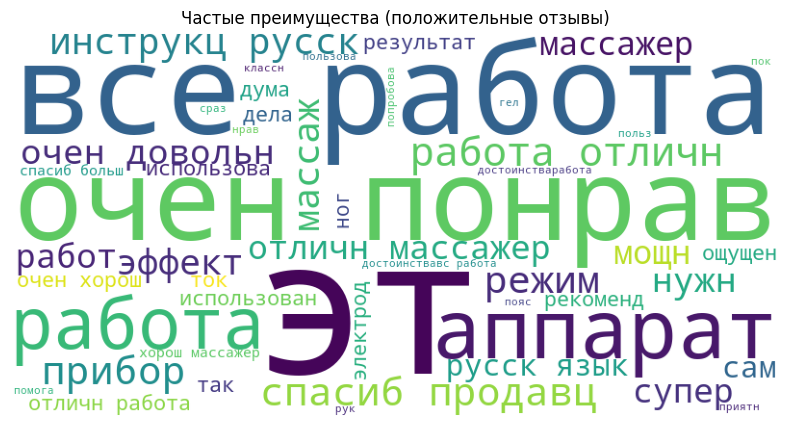

In [67]:
all_positive = " ".join(positive['full_text_clean'])
generate_wordcloud(all_positive, 'Частые преимущества (положительные отзывы)')

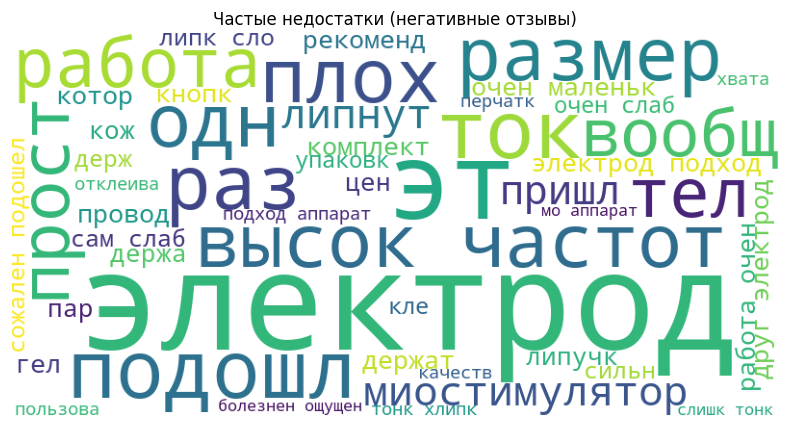

In [21]:
all_negative = " ".join(negative['text_clean'])
generate_wordcloud(all_negative, 'Частые недостатки (негативные отзывы)')

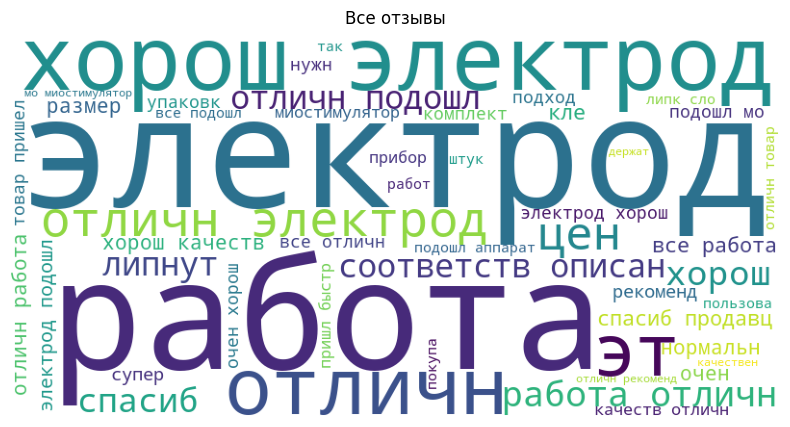

In [22]:
all_feedbacks = " ".join(df['text_clean'])
generate_wordcloud(all_feedbacks, 'Все отзывы')

In [23]:
def get_tfidf_top_features(texts, n=10, use_idf=False, use_mean=True):
    tfidf = TfidfVectorizer(max_features=100, ngram_range=(1, 2))

    tfidf_matrix = tfidf.fit_transform(texts)
    feature_names = tfidf.get_feature_names_out()
    
    if use_idf:
        sorted_indices = tfidf.idf_.argsort()
        return feature_names[sorted_indices][:n].tolist()
    
    if use_mean:
        aggregated = tfidf_matrix.mean(axis=0).A1
    else:
        aggregated = tfidf_matrix.sum(axis=0).A1
    
    sorted_indices = aggregated.argsort()[::-1]  # Сортировка по убыванию
    return feature_names[sorted_indices][:n].tolist()

In [24]:
top_positive_adv = get_tfidf_top_features(positive['text_clean'])
top_negative_dis = get_tfidf_top_features(negative['text_clean'], n=20)
print("Топ-10 слов (положительные отзывы, преимущества):", top_positive_adv)
print("Топ-20 слов (негативные отзывы, недостатки):", top_negative_dis)

Топ-10 слов (положительные отзывы, преимущества): ['отличн', 'работа', 'хорош', 'электрод', 'подошл', 'все', 'спасиб', 'рекоменд', 'очен', 'товар']
Топ-20 слов (негативные отзывы, недостатки): ['работа', 'электрод', 'очен', 'плох', 'товар', 'провод', 'использован', 'ток', 'быстр', 'пришл', 'слаб', 'подошл', 'подошел', 'аппарат', 'возврат', 'подход', 'вмест', 'миостимулятор', 'кле', 'одн']


In [25]:
print(f"Доля позитивных отзывов от общего количества: {(len(positive)*100/(len(positive) + len(negative))):.2f}%")

Доля позитивных отзывов от общего количества: 92.26%


Потребители в основном оценивают данные устроства положительно. 
В негативных отзывах ожидаемо жалобы на брак или работу устройства.

## Выводы:

В основной массе пользователи положительно оценивают данные устройства.

Идеальный продукт выглядит так: портативное, мультизонное устройство средне-высокого или высокого ценового сегмента. Большинство товаров не имеют какого-то очень известного бренда (можно отметить Shuboshi и Yamaguchi), по всей видимости товары данного рынка произодятся китайскими фабриками без явного бренда и получают локальный бренд уже здесь от продавцов. 

Идеальный сегмент для запуска - средне-высокий, поскольку конкуренция в нем относительно невысока, имеется относительно высокий спрос и высокие оценки от потребителей.

Не идеальный - низкий, поскольку на рынке представлено огромное количество данных товаров, также много товаров с очень низкой ценой. Большая конкуренция, следовательно товары скорее всего уже продаются с минимальной наценкой, следовательно высок риск убытков. Среднее количество отзывов в данном сегменте = 75, а значит отдельно взятый миостимулятор из данного сегмента скорее всего не популярен у потребителя.

Сложно сказать есть ли недоцененный сегмент - рынок достаточно "зрелый", в нем представлено много товаров. Товары с низким количеством оценок и высоким рейтингом имеются, однако вероятно они недавно вышли на маркетплейсы и не имеют каких-то отличительных особенностей, либо не пользуются популярностью. Данные товары нуждаются в дополнительных данных и анализе.

Также в ходе данного анализа были исключены товары стоимостью более 10 000 рублей, данных товаров на рынке не много и некоторые из них имеют > 100 отзывов. Возможно имеет смысл рассмотреть нишу этих очень дорогих товаров подробнее. В ней нет массовости, как в низком и среднем сегментах, однако возможно они продаются с большой наценкой, что компенсируют относительную немногочисленность продаж. Для их анализа нужно больше данных, в частности данные о закупочной цене.

В целом данный анализ скорее отображает текущую рыночную ситуацию для данных товаров и рамочно определяет возможные сегменты для запуска, однако для более точных выводов требуются данные из других источников (данные от поставщиков, рассчет дополнительных расходов и т.д.)